In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from zipfile import ZipFile

# Import label encoder
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

# PCA
from sklearn.decomposition import PCA

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf

from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/grive')

Mounted at /content/grive


In [ ]:
# Uzip and extract Dataset

with ZipFile('/content/grive/MyDrive/PINS.zip', 'r') as zipObj:
  zipObj.extractall('/content/grive/MyDrive/Colab Notebooks/CNN 2 Data/PINS_extracted')

In [ ]:
# Read & Load Data function

def load_image(path):
  image = cv2.imread(path, 1)
  # in BGR order. So we need to reverse them
  return image[...,::-1]

In [ ]:
# Defining MetaData Extraction Class with inbuilt image_path function for metadata creation from dataset. Metadata to be used for loading the images from dataset in future code

class MetaDataExtraction():
  def __init__(self, base, name, file):
    self.base = base
    self.name = name
    self.file = file
    
  def __repr__(self):
    return self.image_path()

  def image_path(self):
    return os.path.join(self.base, self.name, self.file) 
  

In [ ]:
# Creating loop for metadata creation for the dataset

def create_metadata(path):
  metadata = []
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      # Check file extension. Allow only jpg/jpeg' files.
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg':
        metadata.append(MetaDataExtraction(path, i, f))
  return np.array(metadata)

metadata = create_metadata('/content/grive/MyDrive/Colab Notebooks/CNN 2 Data/PINS_extracted/PINS')

NameError: ignored

In [ ]:
len(metadata)

10770

In [ ]:
print(metadata)

[/content/grive/MyDrive/Colab Notebooks/CNN 2 Data/PINS_extracted/PINS/pins_Aaron Paul/Aaron Paul0_262.jpg
 /content/grive/MyDrive/Colab Notebooks/CNN 2 Data/PINS_extracted/PINS/pins_Aaron Paul/Aaron Paul101_247.jpg
 /content/grive/MyDrive/Colab Notebooks/CNN 2 Data/PINS_extracted/PINS/pins_Aaron Paul/Aaron Paul101_248.jpg
 ...
 /content/grive/MyDrive/Colab Notebooks/CNN 2 Data/PINS_extracted/PINS/pins_zendaya/zendaya97.jpg
 /content/grive/MyDrive/Colab Notebooks/CNN 2 Data/PINS_extracted/PINS/pins_zendaya/zendaya98.jpg
 /content/grive/MyDrive/Colab Notebooks/CNN 2 Data/PINS_extracted/PINS/pins_zendaya/zendaya99.jpg]


In [ ]:
# Function for Creating Embedding Vectors of each face using VGG Face Model in Keras

def vgg_face_detection():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [ ]:
# Loading VGG weights onto the VGG face Model instance created

model = vgg_face_detection()
model.load_weights('/content/grive/MyDrive/vgg_face_weights.h5')

In [ ]:
# Get model upto last flatten layer #with outputs 2622 units 

vgg_face_detection_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
type(vgg_face_detection_descriptor)

keras.engine.functional.Functional

In [ ]:
# Input and Output for the defined VGG Face model

vgg_face_detection_descriptor.inputs, vgg_face_detection_descriptor.outputs

([<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_13_input')>],
 [<KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten_1')>])

In [ ]:
# Creating loop for extracting embedding vectors for each image in the dataset using

embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    #image = load_image(os.path.join(metadata[i].base, metadata[i].name, metadata[i].file))
    image_path = metadata[i].image_path()
    image = load_image(image_path)
    image = (image / 255.).astype(np.float32)
    image = cv2.resize(image, dsize = (224,224))
    embedding_vector = vgg_face_detection_descriptor.predict(np.expand_dims(image, axis=0))[0]
    embeddings[i] = embedding_vector

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 627ms/step


In [ ]:
embedding_vector

array([ 0.01772302,  0.01064051,  0.01995194, ..., -0.0261843 ,
        0.03288927,  0.0488265 ], dtype=float32)

In [ ]:
# printing shape, sample value, type and value type of embedding vector
print(embedding_vector.shape)
embedding_vector[0], type(embedding_vector), type(embedding_vector[0])

(2622,)


(0.017723016, numpy.ndarray, numpy.float32)

In [ ]:
embeddings

array([[ 0.03170304, -0.0150513 , -0.01243402, ...,  0.00043139,
         0.00219081, -0.00908097],
       [ 0.03497701, -0.00105061, -0.01248934, ..., -0.0105309 ,
         0.00179322,  0.02439155],
       [ 0.02801891, -0.00112631, -0.0126575 , ..., -0.00904751,
        -0.00578403,  0.0212583 ],
       ...,
       [ 0.00965872,  0.0037216 , -0.01345864, ..., -0.01433405,
         0.01899945,  0.03899155],
       [ 0.0023093 ,  0.00094764, -0.00544814, ..., -0.01600495,
         0.01053975,  0.0368325 ],
       [ 0.01772302,  0.01064051,  0.01995194, ..., -0.0261843 ,
         0.03288927,  0.0488265 ]])

In [ ]:
type(embeddings)

numpy.ndarray

In [ ]:
pd.DataFrame(embeddings).to_csv('/content/grive/MyDrive/Colab Notebooks/CNN 2 Data/image_embeddings.csv', index = False)

In [ ]:
embeddings = (pd.read_csv('/content/grive/MyDrive/Colab Notebooks/CNN 2 Data/image_embeddings.csv')).to_numpy()

In [ ]:
type(metadata[0])

__main__.MetaDataExtraction

In [ ]:
embeddings[0]

array([ 0.03170304, -0.0150513 , -0.01243402, ...,  0.00043139,
        0.00219081, -0.00908097])

In [ ]:
# Build distance metrics for identifying the distance between two similar and dissimilar images

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
def show_pair(idx1, idx2):
    pyplot.figure(figsize=(8,3))
    pyplot.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    pyplot.subplot(121)
    pyplot.imshow(load_image(metadata[idx1].image_path()))
    pyplot.subplot(122)
    pyplot.imshow(load_image(metadata[idx2].image_path()));  

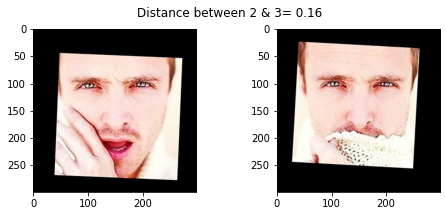

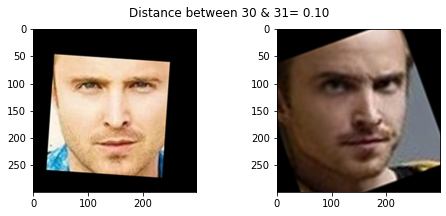

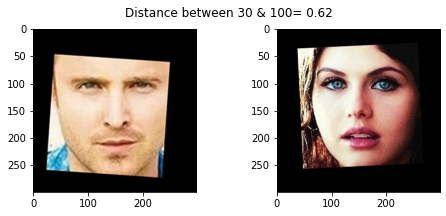

In [ ]:
show_pair(2, 3)
show_pair(30, 31)
show_pair(30,100)

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

In [ ]:
# Label encoding the labels

encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
# Standarize features

scaler = preprocessing.StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
X_train_sc.shape

(9573, 2622)

In [ ]:
# Covariance matrix required for PCA Analysis

covMatrix = np.cov(X_train_sc,rowvar=False)
print(covMatrix)

[[ 1.00010447  0.12132646  0.1137137  ...  0.07724119 -0.12229777
  -0.2517121 ]
 [ 0.12132646  1.00010447  0.22830099 ... -0.03560897  0.2824809
   0.21111878]
 [ 0.1137137   0.22830099  1.00010447 ... -0.11033517  0.06483377
   0.03596998]
 ...
 [ 0.07724119 -0.03560897 -0.11033517 ...  1.00010447 -0.01668781
  -0.09245671]
 [-0.12229777  0.2824809   0.06483377 ... -0.01668781  1.00010447
   0.39523163]
 [-0.2517121   0.21111878  0.03596998 ... -0.09245671  0.39523163
   1.00010447]]


In [ ]:
pca = PCA(n_components = 400)
pca.fit(X_train_sc)

PCA(n_components=400)

In [ ]:
# Percentage of variation explained by each Eigen Vector

print(pca.explained_variance_ratio_)

[1.35760896e-01 5.36909356e-02 3.97598312e-02 3.68961923e-02
 3.40135634e-02 3.15160229e-02 2.58381638e-02 2.35267517e-02
 2.10203993e-02 1.92593194e-02 1.81830005e-02 1.70113714e-02
 1.65312865e-02 1.56603947e-02 1.41845486e-02 1.36818780e-02
 1.30703098e-02 1.21972016e-02 1.15224830e-02 1.13412557e-02
 1.09331116e-02 1.06053397e-02 9.65701858e-03 9.40390421e-03
 9.10234322e-03 8.77397683e-03 8.37293922e-03 7.73171977e-03
 7.67760031e-03 7.37004902e-03 7.04481021e-03 6.55515760e-03
 6.33314826e-03 6.22823071e-03 5.65598601e-03 5.37260356e-03
 5.31277572e-03 5.14217540e-03 5.02336498e-03 4.85127224e-03
 4.45025631e-03 4.30152339e-03 3.99045922e-03 3.94727594e-03
 3.71720698e-03 3.56202711e-03 3.45346834e-03 3.33625091e-03
 3.27140146e-03 3.18419366e-03 3.13594946e-03 3.07630967e-03
 2.90095180e-03 2.81621981e-03 2.77440984e-03 2.72951146e-03
 2.69852703e-03 2.64128530e-03 2.51866383e-03 2.50720451e-03
 2.38211374e-03 2.32164400e-03 2.24760634e-03 2.16735457e-03
 2.13926356e-03 2.046486

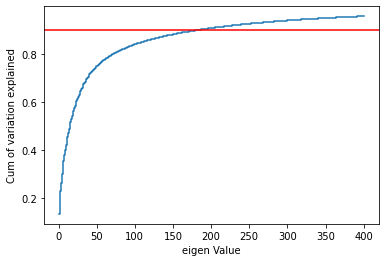

In [ ]:
# % cumulative variance explained using PCA with respect to the eigen values

from matplotlib import pyplot as plt

plt.step(range(1,401),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

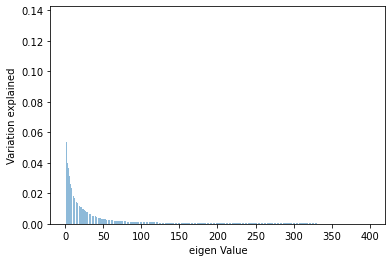

In [ ]:
plt.bar(range(1,401),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

In [ ]:
# Applying 125 principal components to fit the Scaled and balanced X data

pca_125 = PCA(n_components = 125)
pca_125.fit(X_train_sc)
print(pca_125.components_, "\n\n")
print(pca_125.explained_variance_ratio_)
X_train_sc_pca_125 = pca_125.transform(X_train_sc)
X_test_sc_pca_125 = pca_125.transform(X_test_sc)

[[-0.02388178  0.00855287 -0.00328566 ... -0.00801782  0.02118796
   0.03878747]
 [ 0.02073341 -0.00132565  0.00799899 ... -0.02324587 -0.0044313
   0.01125249]
 [ 0.00168995  0.00092016 -0.00703987 ...  0.01173059 -0.00151475
  -0.01618645]
 ...
 [-0.04056871  0.02741877  0.05194851 ... -0.01900394 -0.01586486
   0.00107766]
 [-0.0400473  -0.02477039  0.04761352 ... -0.01020659  0.00903835
  -0.02691069]
 [ 0.02438707 -0.02698309  0.0129182  ... -0.00183799 -0.02103296
  -0.00809509]] 


[0.1357609  0.05369094 0.03975983 0.03689619 0.03401356 0.03151602
 0.02583816 0.02352675 0.0210204  0.01925932 0.018183   0.01701137
 0.01653129 0.01566039 0.01418455 0.01368188 0.01307031 0.0121972
 0.01152248 0.01134126 0.01093311 0.01060534 0.00965702 0.0094039
 0.00910234 0.00877398 0.00837294 0.00773172 0.0076776  0.00737005
 0.00704481 0.00655516 0.00633315 0.00622823 0.00565599 0.0053726
 0.00531278 0.00514218 0.00502336 0.00485127 0.00445026 0.00430152
 0.00399046 0.00394728 0.00371721 0.0035

In [ ]:
# SVC model created and fit on PCA transformed trainset

from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Set random_state
random_state = 2020

svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_sc_pca_125, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_sc_pca_125, y_train)))

SVC accuracy for train set: 0.999


In [ ]:
# Predict
y_pred = svc_pca.predict(X_test_sc_pca_125)

# Accuracy Score
print('Test Accuracy Score: {}'.format(accuracy_score(y_test, y_pred).round(3)))

Test Accuracy Score: 0.95


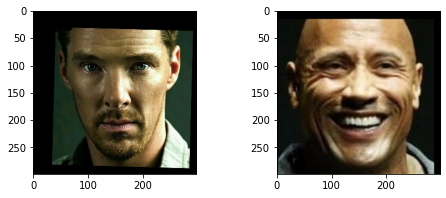

In [ ]:
# Predict for 2 specific example images

image_path_1 = '/content/grive/MyDrive/Colab Notebooks/CNN 2 Data/Benedict Cumberbatch9.jpg'
image_path_2 = '/content/grive/MyDrive/Colab Notebooks/CNN 2 Data/Dwayne Johnson4.jpg'

image_1 = load_image(image_path_1)
image_2 = load_image(image_path_2)

pyplot.figure(figsize=(8,3))
pyplot.subplot(121)
pyplot.imshow(image_1)
pyplot.subplot(122)
pyplot.imshow(image_2)

In [ ]:
# Normalize, Resize and create embedding vectors for example images for model prediction 

image_1 = (image_1 / 255.).astype(np.float32)
image_1 = cv2.resize(image_1, dsize = (224,224))
embedding_vector_1 = vgg_face_detection_descriptor.predict(np.expand_dims(image_1, axis=0))[0]

image_2 = (image_2 / 255.).astype(np.float32)
image_2 = cv2.resize(image_2, dsize = (224,224))
embedding_vector_2 = vgg_face_detection_descriptor.predict(np.expand_dims(image_2, axis=0))[0]


1/1 [==============================] - 1s 1s/step


In [ ]:
# Reshape embedding vectors of 2 example images
embedding_vector_1 = np.reshape(embedding_vector, (1, 2622))
embedding_vector_2 = np.reshape(embedding_vector, (1, 2622))
embedding_vector_1.shape

(1, 2622)

In [ ]:
# Scale embedding vectors

embedding_vector_sc_1 = scaler.fit_transform(embedding_vector_1)
embedding_vector_pca_1 = pca_125.transform(embedding_vector_sc_1)

embedding_vector_sc_2 = scaler.fit_transform(embedding_vector_2)
embedding_vector_pca_2 = pca_125.transform(embedding_vector_sc_2)

In [ ]:
# Predict from transformed embedding vectors for 2 example images

y_pred_1 = svc_pca.predict(embedding_vector_pca_1)
y_pred_2 = svc_pca.predict(embedding_vector_pca_2)

print ('Prediction for Image 1 - Benedict Cumberbatch : ', y_pred_1)
print ('Prediction for Image 2 - Dwayne Johnson : ', y_pred_2)

Prediction for Image 1 - Benedict Cumberbatch :  [89]
Prediction for Image 2 - Dwayne Johnson :  [89]


In [ ]:
%%shell
jupyter nbconvert --to html /content/Computer_Vision_Project_2.ipynb

[NbConvertApp] Converting notebook /content/Computer_Vision_Project_2.ipynb to html
[NbConvertApp] Writing 2783982 bytes to /content/Computer_Vision_Project_2.html
